# Starter code: from lecture 3

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()

In [3]:
len(words)

32033

In [4]:
# build vocab of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)
print(len(words))

32033


In [6]:
# build the dataset
block_size = 3

def build_dataset(words):
    X,Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y
    
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = build_dataset(words=words[:n1])
Xdev,Ydev = build_dataset(words=words[n1:n2])
Xte,Yte = build_dataset(words=words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
# for x,y in zip(Xtr[:20], Ytr[:20]):
#     print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

In [9]:
from typing import Any


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5 # making init - Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [10]:
torch.manual_seed(42)

In [11]:
n_embd = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

# parameters init
with torch.no_grad():
    layers[-1].weight *= 0.1 # making the last layer less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # counting number of total params in network

for p in parameters:
    p.requires_grad = True

12097


In [12]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    
    # calculate loss
    loss = F.cross_entropy(x, Yb)

    # zero the gradients
    for p in parameters:
        p.grad = None
    
    # backward pass
    loss.backward()

    # update : simple SGD
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000 == 0: # print every once in a while
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0 /  200000: 3.2966
  10000 /  200000: 2.2322
  20000 /  200000: 2.4111
  30000 /  200000: 2.1004
  40000 /  200000: 2.3157
  50000 /  200000: 2.2104
  60000 /  200000: 1.9653
  70000 /  200000: 1.9767
  80000 /  200000: 2.6738
  90000 /  200000: 2.0837
 100000 /  200000: 2.2730
 110000 /  200000: 1.7491
 120000 /  200000: 2.2891
 130000 /  200000: 2.3443
 140000 /  200000: 2.1731
 150000 /  200000: 1.8246
 160000 /  200000: 1.7614
 170000 /  200000: 2.2419
 180000 /  200000: 2.0803
 190000 /  200000: 2.1326


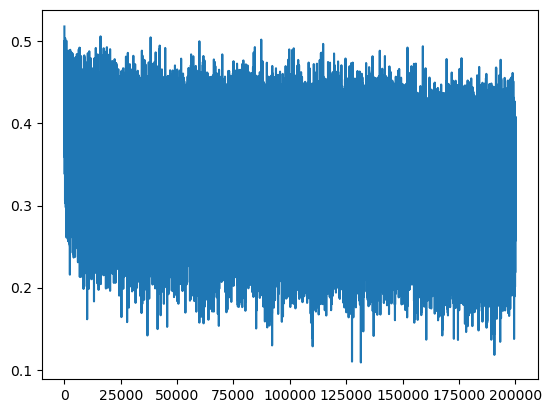

In [13]:
plt.plot(lossi)

In [14]:
# put the layers into eval mode (needed for BatchNorm especially)
for layer in layers:
    layer.training = False

In [15]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0],-1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0583250522613525
val 2.1065289974212646


In [22]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass
        # emb = C[torch.tensor(context)] # would have given shape (3,10)
        emb = C[torch.tensor([context])] # gives shape (1,3,10)
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

tyre.
dia.
beir.
damelays.
kascacolton.
edinicioannie.
karleah.
arleniya.
doslaycensayah.
marelizion.
tamura.
fraelayanna.
kalin.
aldoncreigh.
katiya.
shalle.
ris.
taya.
abbikkingan.
azimith.


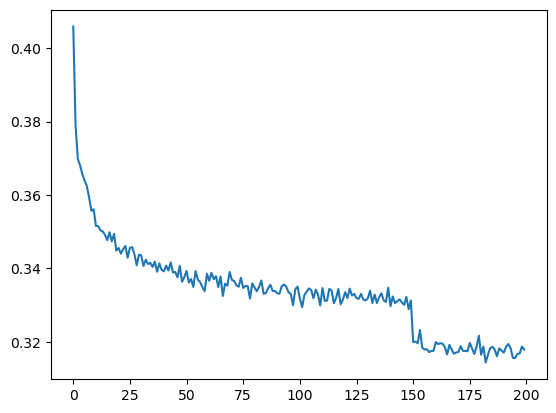

In [25]:
# fixing the learning rate plot
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

# Simplify forward pass, new layers

In [94]:
# to further simplify forward pass

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

In [28]:
n_embd = 10
n_hidden = 200

layers = [
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

# parameters init
with torch.no_grad():
    layers[-1].weight *= 0.1 # making the last layer less confident

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # counting number of total params in network

for p in parameters:
    p.requires_grad = True

12097


In [29]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]

    # forward pass
    x = Xb
    for layer in layers:
        x = layer(x)
    
    # calculate loss
    loss = F.cross_entropy(x, Yb)

    # zero the gradients
    for p in parameters:
        p.grad = None
    
    # backward pass
    loss.backward()

    # update : simple SGD
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000 == 0: # print every once in a while
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0 /  200000: 3.2929


# PyTorch CONTAINERS

In [52]:
# build the dataset
block_size = 8 #3

def build_dataset(words):
    X,Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y
    
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = build_dataset(words=words[:n1])
Xdev,Ydev = build_dataset(words=words[n1:n2])
Xte,Yte = build_dataset(words=words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [53]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [54]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameters init
with torch.no_grad():
    layers[-1].weight *= 0.1 # making the last layer less confident

parameters = model.parameters() #[p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # counting number of total params in network

for p in parameters:
    p.requires_grad = True

22097


In [55]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    # calculate loss
    loss = F.cross_entropy(logits, Yb)

    # zero the gradients
    for p in parameters:
        p.grad = None
    
    # backward pass
    loss.backward()

    # update : simple SGD
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000 == 0: # print every once in a while
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0 /  200000: 3.5364
  10000 /  200000: 2.6143
  20000 /  200000: 2.0172
  30000 /  200000: 2.1727
  40000 /  200000: 2.1578
  50000 /  200000: 2.0263
  60000 /  200000: 2.5499
  70000 /  200000: 2.1290
  80000 /  200000: 2.0202
  90000 /  200000: 1.7371
 100000 /  200000: 1.9581
 110000 /  200000: 1.6765
 120000 /  200000: 2.0676
 130000 /  200000: 1.8515
 140000 /  200000: 1.9732
 150000 /  200000: 1.7613
 160000 /  200000: 2.0884
 170000 /  200000: 2.0102
 180000 /  200000: 1.6919
 190000 /  200000: 1.9062


In [56]:
for layer in model.layers:
    layer.training = False

In [57]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9188401699066162
val 2.027010202407837


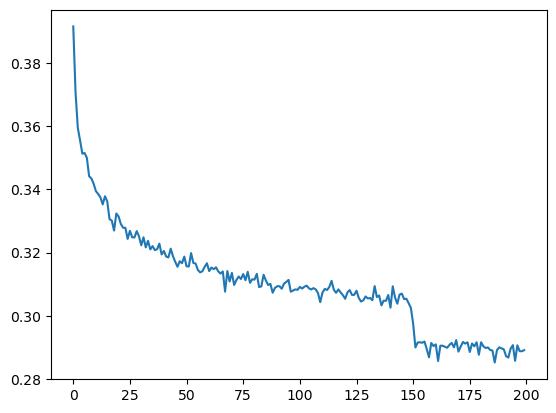

In [58]:
# fixing the learning rate plot
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [59]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass
        # emb = C[torch.tensor(context)] # would have given shape (3,10)
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

aleyna.
mackylin.
dem.
sayda.
malaya.
tahrcha.
zynny.
denicri.
camylo.
calla.
yuliyan.
roage.
jasliene.
deshan.
delwo.
araveenn.
charlyn.
elenna.
daanes.
asylynn.


# Implementing WaveNet

## We basically want to implement Fig.3 from "paper wavenet"
- Where progressive fusion of 2 characters (or tokens) from previous layer happens.

##### Exploring the internals of matrix multiplication & view in PyTorch

In [60]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # let's look at a batch of 4 examples
Xb,Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  9, 26,  1,  9,  1,  8],
        [ 0,  0,  0, 13,  9, 18,  9,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [64]:
model.layers[0].out.shape # output of Embedding layer
# 10 dimensional embedding for each integer in (4,8) Xb gets plucked out

torch.Size([4, 8, 10])

In [66]:
model.layers[1].out.shape # output of Flatten layer
# concatenates the 8, 10-d vectors to make 80

torch.Size([4, 80])

In [67]:
model.layers[2].out.shape # output of Linear layer
# matrix multiplication with weight matrix
# [4,80] @ [80,200] --> [4,200]

torch.Size([4, 200])

In [69]:
# A SUPRISING PROPERTY of matrix multiplication in PyTorch
# NO MATTER THE NUMBER OF DIMENSIONS IN MATRIX; MATRIX MULTIPLICATION ONLY HAPPENS WITH LAST DIM
# [4,5,2,20] @ [20,200] --> [4,5,2,200]

(torch.randn(4,5,2,20) @ torch.randn(20,200) + torch.randn(200)).shape

# we need to use this property in our implementation of WaveNet now

torch.Size([4, 5, 2, 200])

- from our last update of 8 in block_size: we have 8 characters coming in
- ### 1 2 3 4 5 6 7 8
- We don't want to matrix multiply 80 into weight matrix immediately
- Instead, we want to group them into 2 consecutive elements
- ### (1 2) (3 4) (5 6) (7 8)
- Each of these groups will have to be FLATTENed out and sent to matrix mulitply
- So these 4 groups will be processed in parallel,
    - so they will kind of become a 2nd BATCH DIM

In [70]:
# actually we want something like this happening in linear layer

(torch.randn(4,4,20) @ torch.randn(20,200) + torch.randn(200)).shape
# 0th dim - 4 batch_size; 1st dim - 4 groups of 2 chars each; 2nd dim - 2, 10d vectors concatenated 

torch.Size([4, 4, 200])

In [73]:
# we need to pack every 2 consecutive characters from **Xb**
Xb

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  9, 26,  1,  9,  1,  8],
        [ 0,  0,  0, 13,  9, 18,  9,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

- we want our Flattern layer to create (4,4,20) instead of (4,80)

In [74]:
e = torch.randn(4,8,10)
e.view(4,-1).shape # current Flatten layer

torch.Size([4, 80])

In [79]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [84]:
# indexing for EVEN position elements
# list(range(10))[::2] 
e[:, ::2, :].shape

torch.Size([4, 4, 10])

In [85]:
# indexing for ODD position elements
# list(range(10))[1::2] 
e[:, 1::2, :].shape

torch.Size([4, 4, 10])

In [86]:
torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2).shape

torch.Size([4, 4, 20])

In [87]:
# this can also be simply done with "view"
e.view(4,4,-1).shape

torch.Size([4, 4, 20])

In [89]:
(e.view(4,4,-1) == torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)).all()

tensor(True)

In [115]:
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B,T,C = x.shape
        # x = x.view(B, -1, C*n)
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(dim=1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

In [139]:
n_embd = 10
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_embd),
    # FlattenConsecutive(8),            # this should replicate our normal case with 8 block_size, w/o any pairing
    # Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameters init
with torch.no_grad():
    layers[-1].weight *= 0.1 # making the last layer less confident

parameters = model.parameters() #[p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # counting number of total params in network

for p in parameters:
    p.requires_grad = True

22397


In [140]:
logits = model(Xb)

In [141]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [142]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    # calculate loss
    loss = F.cross_entropy(logits, Yb)

    # zero the gradients
    for p in parameters:
        p.grad = None
    
    # backward pass
    loss.backward()

    # update : simple SGD
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000 == 0: # print every once in a while
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0 /  200000: 3.5349
  10000 /  200000: 2.3441
  20000 /  200000: 2.1199
  30000 /  200000: 1.8013
  40000 /  200000: 2.2160
  50000 /  200000: 2.0621
  60000 /  200000: 1.9906
  70000 /  200000: 1.9615
  80000 /  200000: 2.1105
  90000 /  200000: 1.9965
 100000 /  200000: 2.4726
 110000 /  200000: 2.1534
 120000 /  200000: 1.8759
 130000 /  200000: 2.2257
 140000 /  200000: 2.0678
 150000 /  200000: 1.6743
 160000 /  200000: 1.9186
 170000 /  200000: 1.8563
 180000 /  200000: 1.7848
 190000 /  200000: 1.9041


In [133]:
model.layers[3].out.shape

torch.Size([22655, 4, 200])

In [131]:
for layer in model.layers:
    layer.training = False

In [132]:
split_loss('train')
split_loss('val')

train 1.7779555320739746
val 1.9856760501861572


- In our current implementation of BatchNorm1d
    - it only handle 2d input x
    - we must change it to handle more than 2 dimensions

In [143]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [146]:
n_embd = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embd),
    # FlattenConsecutive(8),            # this should replicate our normal case with 8 block_size, w/o any pairing
    # Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameters init
with torch.no_grad():
    layers[-1].weight *= 0.1 # making the last layer less confident

parameters = model.parameters() #[p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # counting number of total params in network

for p in parameters:
    p.requires_grad = True

76579


In [147]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    # calculate loss
    loss = F.cross_entropy(logits, Yb)

    # zero the gradients
    for p in parameters:
        p.grad = None
    
    # backward pass
    loss.backward()

    # update : simple SGD
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000 == 0: # print every once in a while
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0 /  200000: 3.3628
  10000 /  200000: 2.2569
  20000 /  200000: 2.4783
  30000 /  200000: 1.9981
  40000 /  200000: 2.3382
  50000 /  200000: 1.8019
  60000 /  200000: 1.8576
  70000 /  200000: 1.5993
  80000 /  200000: 2.3144
  90000 /  200000: 1.7847
 100000 /  200000: 1.2561
 110000 /  200000: 2.0393
 120000 /  200000: 1.7662
 130000 /  200000: 1.8421
 140000 /  200000: 1.6151
 150000 /  200000: 2.2471
 160000 /  200000: 1.6646
 170000 /  200000: 1.8487
 180000 /  200000: 2.1174
 190000 /  200000: 1.9054


In [148]:
model.layers[3].out.shape

torch.Size([32, 4, 128])

In [149]:
for layer in model.layers:
    layer.training = False

# evaluate the loss
split_loss('train')
split_loss('val')

train 1.8073965311050415
val 1.9859343767166138


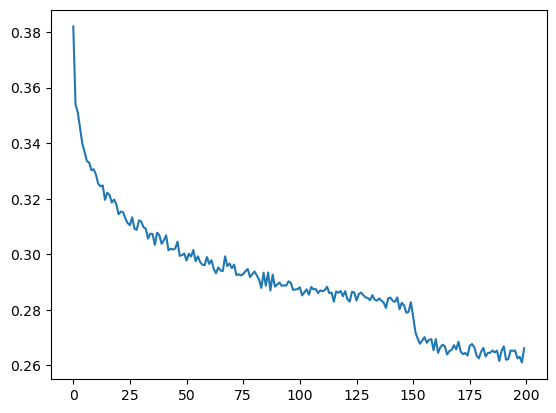

In [150]:
# fixing the learning rate plot
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [151]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass
        # emb = C[torch.tensor(context)] # would have given shape (3,10)
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

emoaline.
talmag.
rolan.
roselynn.
rinabella.
shaker.
naven.
wendalyn.
zahan.
raphir.
leeda.
kennadi.
mohamid.
rosey.
chyl.
renlondes.
haru.
hawshuo.
aaquan.
abene.
